In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
from torchsummary import summary
from piqa import SSIM
cudnn.benchmark = True
plt.ion()

Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [3]:
#apple
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


Load Data

In [4]:

train_data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        #transforms.AugMix(),
        transforms.ToTensor(),
    ])


data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = '/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/train/good'
train_dataset = CustomDataset(data_dir,train_data_transforms)
test_dataset = CustomDataset('/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/test/mix',data_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader),len(test_dataloader))

43 11 40


View Data

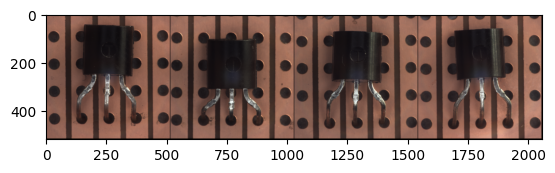

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [6]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [7]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256*13*13, 2),#13*13  #29*29
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 256*13*13),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=True),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [8]:
testModel = AutoEncoder()
summary(testModel, (3, 512, 512),4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 256, 256]             392
       BatchNorm2d-2           [4, 8, 256, 256]              16
              ReLU-3           [4, 8, 256, 256]               0
            Conv2d-4          [4, 16, 128, 128]           2,064
       BatchNorm2d-5          [4, 16, 128, 128]              32
              ReLU-6          [4, 16, 128, 128]               0
            Conv2d-7            [4, 32, 64, 64]           8,224
       BatchNorm2d-8            [4, 32, 64, 64]              64
              ReLU-9            [4, 32, 64, 64]               0
           Conv2d-10            [4, 64, 32, 32]          32,832
      BatchNorm2d-11            [4, 64, 32, 32]             128
             ReLU-12            [4, 64, 32, 32]               0
           Conv2d-13           [4, 128, 16, 16]         131,200
      BatchNorm2d-14           [4, 128,

Model, Loss & Optimizer

In [9]:
torch.manual_seed(0)

## piqa ssim
class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

ssimloss = SSIMLoss().to(device)

lr= 0.001
num_epochs = 50

#loss = torch.nn.MSELoss()
loss = torch.nn.L1Loss()
model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs * len(train_dataloader),
      eta_min= 1e-6/lr)

model.to(device)
torch.set_printoptions(threshold=10_000)

Train

In [10]:
def train_epoch(model, device, dataloader, loss_fn, optimizer,scheduler):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        # # max value 1 ------ ssimloss
        # dd = decoded_data.clone()
        # dd[decoded_data>=1]=1
        # loss = loss_fn(decoded_data, image_batch) + ssimloss(image_batch,dd)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [11]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [12]:
def plot_ae_outputs(model,n=10):
  # inputs = next(iter(val_dataloader))
  # out = torchvision.utils.make_grid(inputs)
  # imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training

/Users/nayansavaliya/Desktop/AnomalyDetection/ad-venv/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 1/50 	 train loss 0.17173096537590027 	 val loss 0.12143780291080475


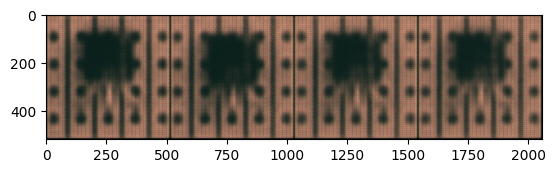

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 2/50 	 train loss 0.07668550312519073 	 val loss 0.06228265166282654


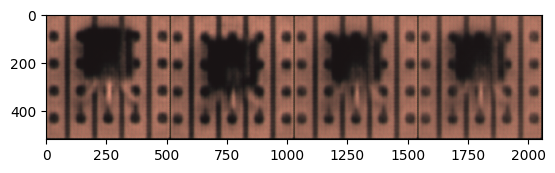


 EPOCH 3/50 	 train loss 0.055654603987932205 	 val loss 0.052929483354091644


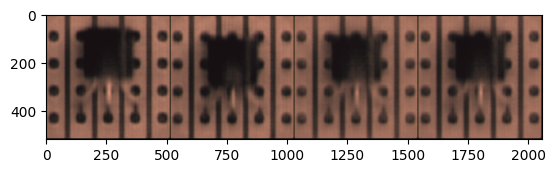


 EPOCH 4/50 	 train loss 0.05195429548621178 	 val loss 0.04948657006025314


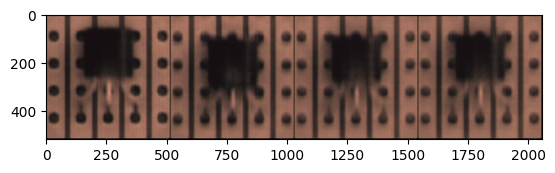


 EPOCH 5/50 	 train loss 0.049814142286777496 	 val loss 0.048463571816682816


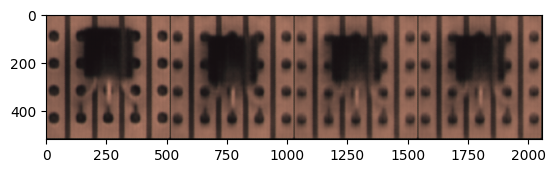


 EPOCH 6/50 	 train loss 0.048011403530836105 	 val loss 0.048920247703790665


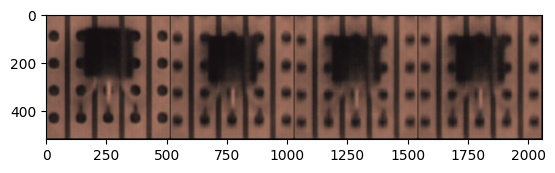


 EPOCH 7/50 	 train loss 0.04679100960493088 	 val loss 0.047432322055101395


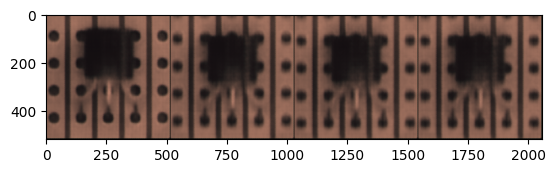


 EPOCH 8/50 	 train loss 0.04650425538420677 	 val loss 0.045527976006269455


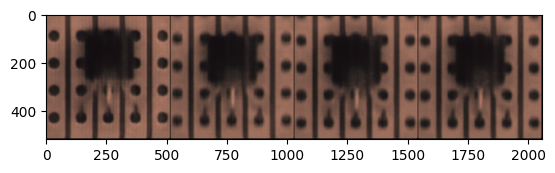


 EPOCH 9/50 	 train loss 0.04580909013748169 	 val loss 0.04667985066771507


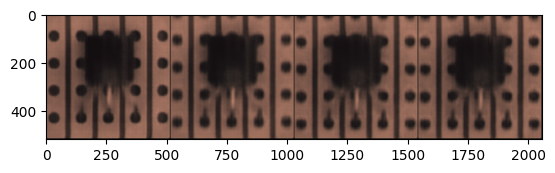


 EPOCH 10/50 	 train loss 0.044561464339494705 	 val loss 0.044826146215200424


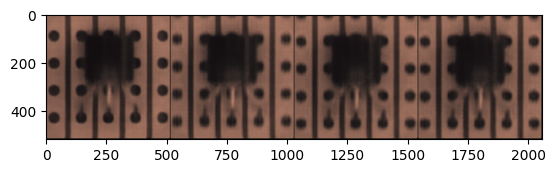


 EPOCH 11/50 	 train loss 0.04337278753519058 	 val loss 0.043656859546899796


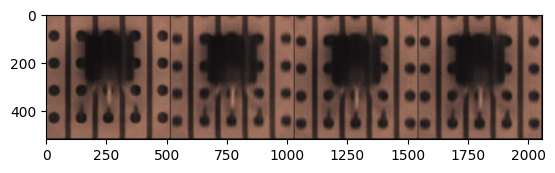


 EPOCH 12/50 	 train loss 0.04261957108974457 	 val loss 0.04291362687945366


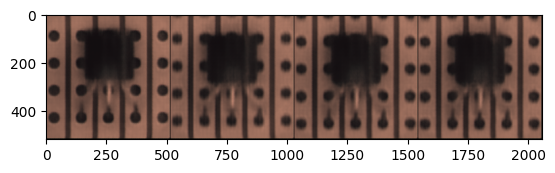


 EPOCH 13/50 	 train loss 0.04206621274352074 	 val loss 0.04350516200065613


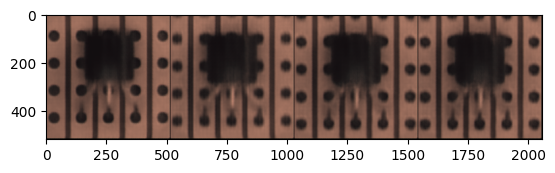


 EPOCH 14/50 	 train loss 0.041716787964105606 	 val loss 0.04291506111621857


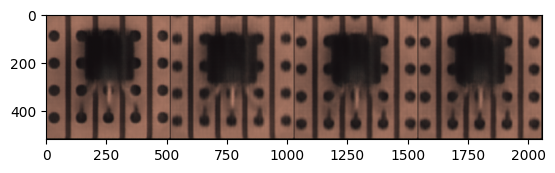


 EPOCH 15/50 	 train loss 0.04134340211749077 	 val loss 0.041102085262537


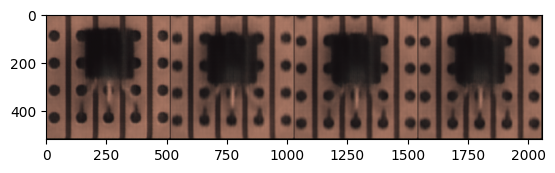


 EPOCH 16/50 	 train loss 0.041313979774713516 	 val loss 0.04282015189528465


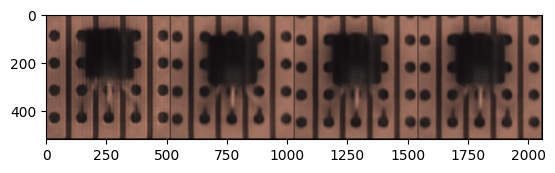


 EPOCH 17/50 	 train loss 0.04147759824991226 	 val loss 0.04137542471289635


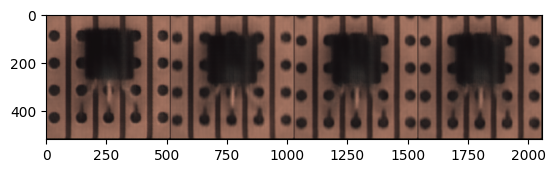


 EPOCH 18/50 	 train loss 0.04112217202782631 	 val loss 0.040958866477012634


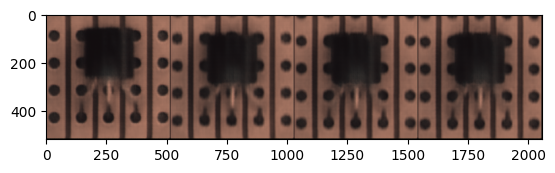


 EPOCH 19/50 	 train loss 0.04060867056250572 	 val loss 0.04097229987382889


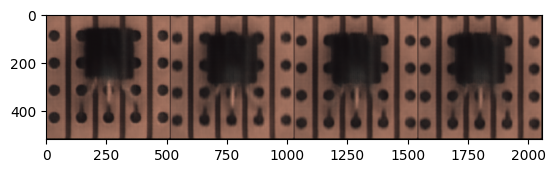


 EPOCH 20/50 	 train loss 0.04042959213256836 	 val loss 0.04095928743481636


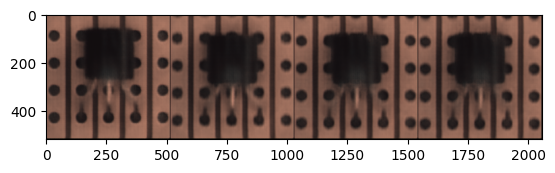


 EPOCH 21/50 	 train loss 0.04039971902966499 	 val loss 0.041284963488578796


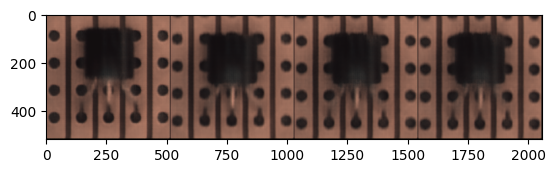


 EPOCH 22/50 	 train loss 0.04023481532931328 	 val loss 0.042220842093229294


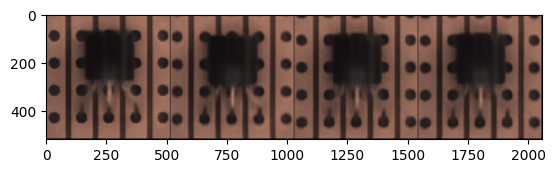


 EPOCH 23/50 	 train loss 0.040071453899145126 	 val loss 0.041125137358903885


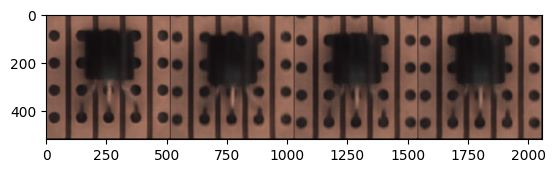


 EPOCH 24/50 	 train loss 0.04003774747252464 	 val loss 0.041435252875089645


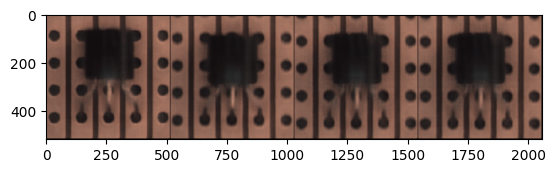


 EPOCH 25/50 	 train loss 0.0400351919233799 	 val loss 0.039725411683321


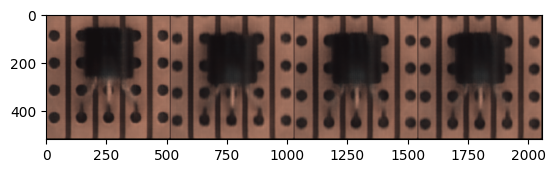


 EPOCH 26/50 	 train loss 0.03958098590373993 	 val loss 0.04157515615224838


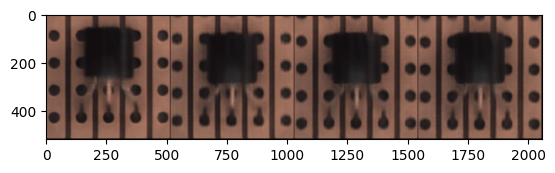


 EPOCH 27/50 	 train loss 0.039143454283475876 	 val loss 0.04292767494916916


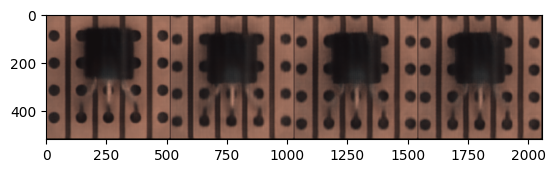


 EPOCH 28/50 	 train loss 0.039653435349464417 	 val loss 0.0402618832886219


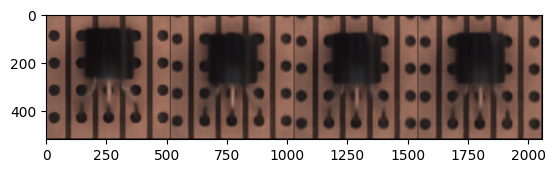


 EPOCH 29/50 	 train loss 0.03895764425396919 	 val loss 0.039491068571805954


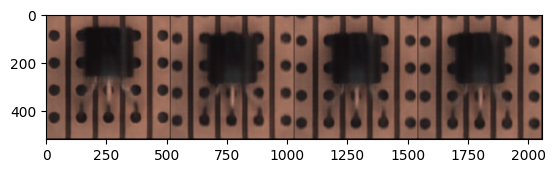


 EPOCH 30/50 	 train loss 0.038386717438697815 	 val loss 0.040530264377593994


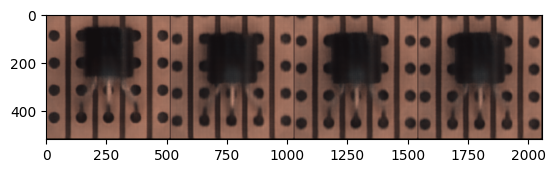


 EPOCH 31/50 	 train loss 0.03803842514753342 	 val loss 0.04179088771343231


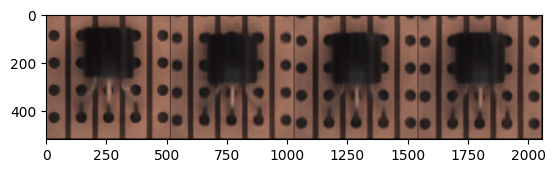


 EPOCH 32/50 	 train loss 0.03830568864941597 	 val loss 0.040420323610305786


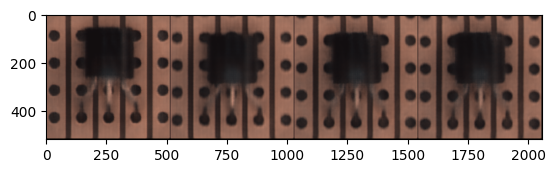


 EPOCH 33/50 	 train loss 0.03888013958930969 	 val loss 0.03942595422267914


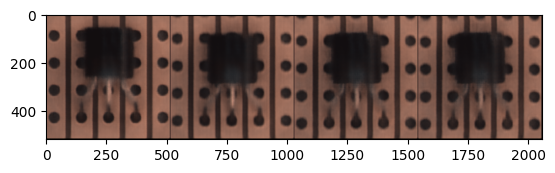


 EPOCH 34/50 	 train loss 0.03837380185723305 	 val loss 0.03919229283928871


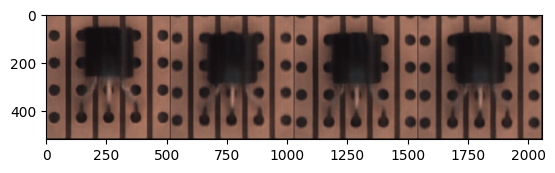


 EPOCH 35/50 	 train loss 0.03811703622341156 	 val loss 0.03936179354786873


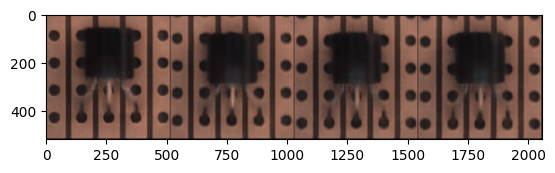


 EPOCH 36/50 	 train loss 0.03903839364647865 	 val loss 0.04187876731157303


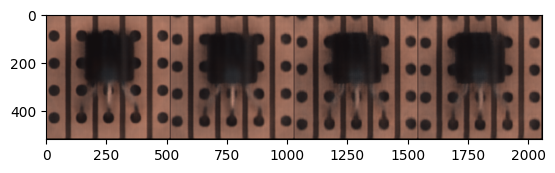


 EPOCH 37/50 	 train loss 0.03861716017127037 	 val loss 0.04196321219205856


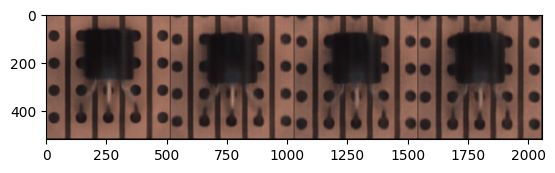


 EPOCH 38/50 	 train loss 0.038071248680353165 	 val loss 0.04452387988567352


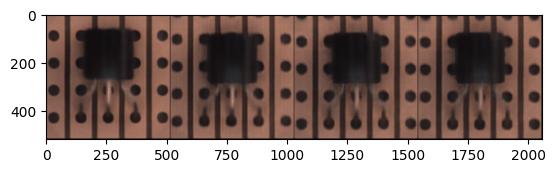


 EPOCH 39/50 	 train loss 0.03724370896816254 	 val loss 0.040998425334692


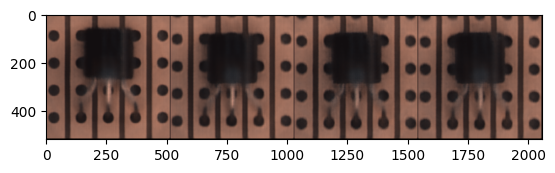


 EPOCH 40/50 	 train loss 0.03709520399570465 	 val loss 0.04134844243526459


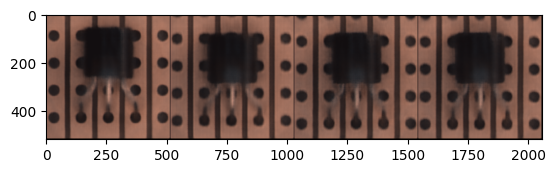


 EPOCH 41/50 	 train loss 0.03766443207859993 	 val loss 0.03916303440928459


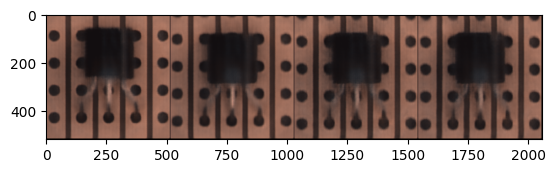


 EPOCH 42/50 	 train loss 0.03833641856908798 	 val loss 0.038990579545497894


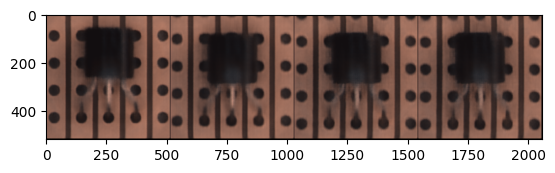


 EPOCH 43/50 	 train loss 0.03691503778100014 	 val loss 0.040745172649621964


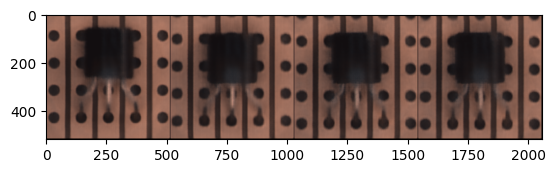


 EPOCH 44/50 	 train loss 0.03685367479920387 	 val loss 0.04098181053996086


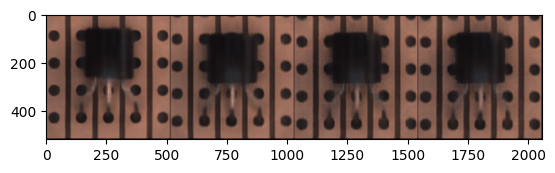


 EPOCH 45/50 	 train loss 0.03669988363981247 	 val loss 0.04448895901441574


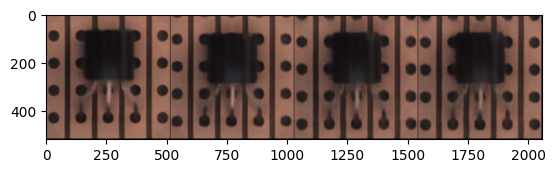


 EPOCH 46/50 	 train loss 0.037311967462301254 	 val loss 0.04012952372431755


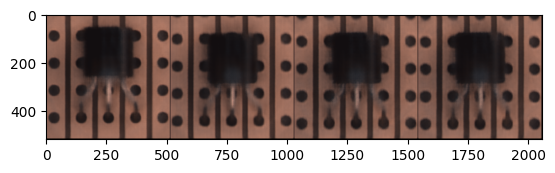


 EPOCH 47/50 	 train loss 0.03726973384618759 	 val loss 0.03845256194472313


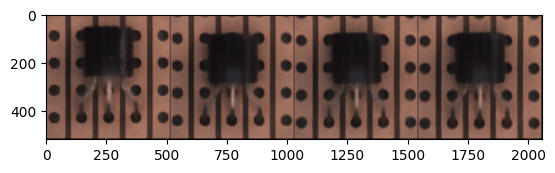


 EPOCH 48/50 	 train loss 0.03700162097811699 	 val loss 0.03917773813009262


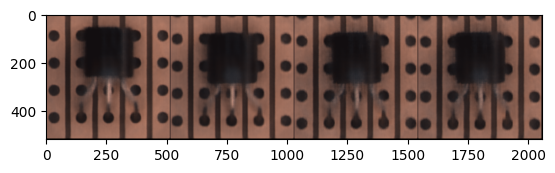


 EPOCH 49/50 	 train loss 0.03687632456421852 	 val loss 0.03850696608424187


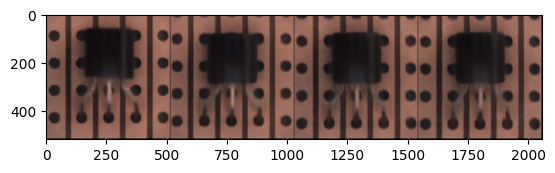


 EPOCH 50/50 	 train loss 0.0364636667072773 	 val loss 0.03971949219703674


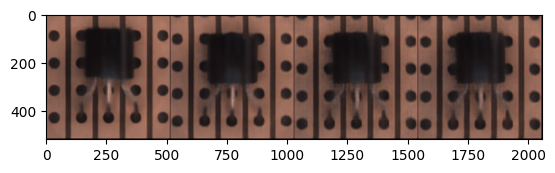

In [13]:
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim,scheduler)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Temp Section do not delete

torch.Size([1, 3, 512, 512])
tensor([[[[0.3463, 0.5025, 0.4901,  ..., 0.5778, 0.4167, 0.2456],
          [0.3853, 0.4873, 0.5638,  ..., 0.5850, 0.5555, 0.4223],
          [0.5680, 0.5802, 0.5924,  ..., 0.6005, 0.5509, 0.4638],
          ...,
          [0.4111, 0.5774, 0.5578,  ..., 0.5820, 0.5419, 0.4406],
          [0.3833, 0.5551, 0.5715,  ..., 0.5535, 0.4292, 0.3976],
          [0.1454, 0.4215, 0.4739,  ..., 0.4473, 0.4422, 0.2599]],

         [[0.3221, 0.3960, 0.4130,  ..., 0.3453, 0.2653, 0.2276],
          [0.3313, 0.3717, 0.4575,  ..., 0.4098, 0.3467, 0.3212],
          [0.2611, 0.3872, 0.3990,  ..., 0.4307, 0.3940, 0.3589],
          ...,
          [0.3434, 0.4259, 0.4317,  ..., 0.3868, 0.3560, 0.3459],
          [0.2613, 0.3815, 0.4127,  ..., 0.3681, 0.3414, 0.3231],
          [0.1964, 0.2961, 0.3524,  ..., 0.3393, 0.3114, 0.2411]],

         [[0.2176, 0.3418, 0.3651,  ..., 0.3173, 0.2725, 0.1212],
          [0.2721, 0.3973, 0.3677,  ..., 0.3616, 0.3307, 0.2612],
          [0.

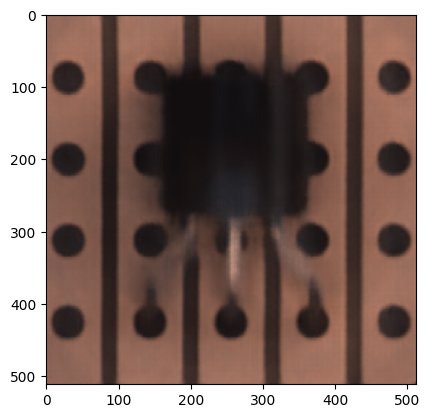

In [14]:
inputs = next(iter(test_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
print(out)
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

Loss Plot

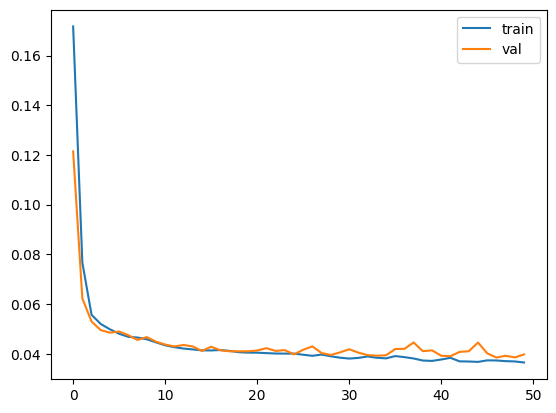

In [15]:
plt.plot(diz_loss['train_loss'],label='train')
plt.plot(diz_loss['val_loss'],label='val')
plt.legend()
plt.show()

Latent Representation

In [16]:
train = []
val = []
test = []
data = []
with torch.no_grad():
        for image_batch in train_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            train.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            val.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            test.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        train = torch.cat(train)
        val = torch.cat(val)
        test = torch.cat(test)
        data = torch.cat(data)


/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_2157/3762618135.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(train[:, 0], train[:, 1],cmap='hot',label='train')
/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_2157/3762618135.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val[:, 0], val[:, 1],c='#FFA500', cmap='hot',label='val')
/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_2157/3762618135.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(test[:, 0], test[:, 1],c='#00FF00', cmap='hot',label='test')


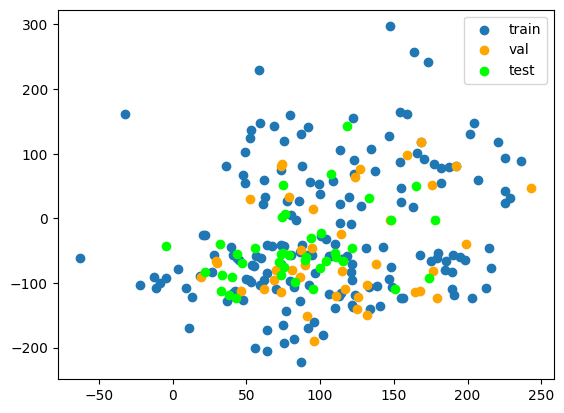

In [17]:

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(train[:, 0], train[:, 1],cmap='hot',label='train')
ax.scatter(val[:, 0], val[:, 1],c='#FFA500', cmap='hot',label='val')
ax.scatter(test[:, 0], test[:, 1],c='#00FF00', cmap='hot',label='test')

# ax = fig.add_subplot(projection='3d')
# ax.scatter(train[:, 0], train[:, 1], train[:, 2],cmap='hot',label='train')
# ax.scatter(val[:, 0], val[:, 1], val[:, 2],c='#FFA500', cmap='hot',label='val')
# ax.scatter(test[:, 0], test[:, 1], test[:, 2],c='#00FF00', cmap='hot',label='test')

# Display the plot
plt.legend()
plt.show()

[1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0
 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1
 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0
 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1]
[[127.29446691  84.06307341]
 [ 91.49718653 -88.23325843]]


/Users/nayansavaliya/Desktop/AnomalyDetection/ad-venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


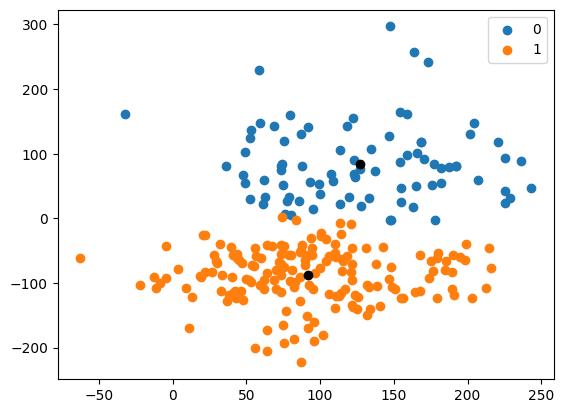

In [18]:
from sklearn import cluster
kmeans = cluster.KMeans(init='k-means++',n_clusters=2, random_state=0).fit(data)

labels = kmeans.labels_
print(labels)
centroids = kmeans.cluster_centers_
print(centroids)
u_labels = np.unique(labels)

fig = plt.figure()
ax = fig.add_subplot()
for i in u_labels:
    ax.scatter(data[labels == i , 0] , data[labels == i , 1] , label = i)

ax.scatter(centroids[:,0] , centroids[:,1] , color = 'k')
plt.legend()
plt.show()



In [23]:
# Kmeans prediction

kmeans.predict(train)

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1], dtype=int32)

In [20]:
# from sklearn.mixture import GaussianMixture
# gm = GaussianMixture(n_components=2, random_state=0).fit(data)
# print(gm.means_)
# print(gm.predict(train))

Encoder-Decoder Output Loss Histogram

In [21]:
model.eval()
clean = []
defect = []

for image_batch in train_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = loss(decoded_data, image_batch).detach()
    clean.append(mse.cpu().detach().item())

for image_batch in test_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = loss(decoded_data, image_batch).detach()
    defect.append(mse.cpu().detach().item())





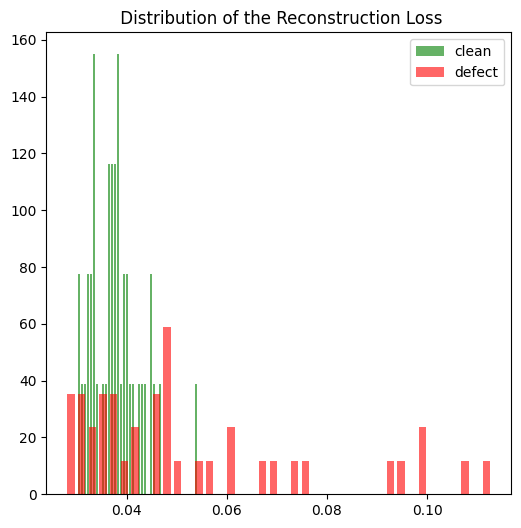

[0.044680871069431305, 0.03235834091901779, 0.03324586898088455, 0.04654760658740997, 0.03858847916126251, 0.037637703120708466, 0.054191600531339645, 0.03153479844331741, 0.03723183274269104, 0.04300261661410332, 0.03710814192891121, 0.0377182811498642, 0.03675229102373123, 0.039880409836769104, 0.04459385201334953, 0.03808412328362465, 0.03277375549077988, 0.03996501863002777, 0.038465071469545364, 0.04135064408183098, 0.03547520563006401, 0.04532083496451378, 0.04350745677947998, 0.03588481247425079, 0.038139745593070984, 0.0373552143573761, 0.03629416227340698, 0.03058665059506893, 0.03350275382399559, 0.030168481171131134, 0.042268674820661545, 0.03286883980035782, 0.031106706708669662, 0.03386138007044792, 0.03967508301138878, 0.0375819057226181, 0.039184194058179855, 0.038264159113168716, 0.03371364623308182, 0.040895044803619385, 0.03360670059919357, 0.032242607325315475, 0.03650689870119095] [0.060347020626068115, 0.033463455736637115, 0.05404280871152878, 0.06086371839046478,

In [22]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=40, density=True, label="clean", alpha=.6, color="green", rwidth=0.7)
ax.hist(defect, bins=40, density=True, label="defect", alpha=.6, color="red", rwidth=0.7)

plt.title(" Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

print(clean, defect)